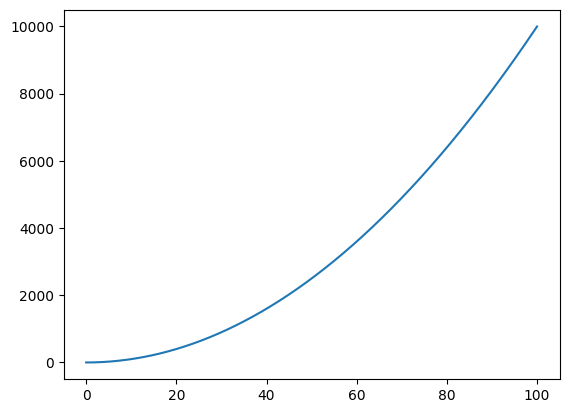

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
x = np.linspace(0,100,1000)
y = x**2

plt.plot(x,y)